# Image inpainting

Example of image inpainting using NIHT


In [1]:
import sys
sys.path.append("../")

import numpy as np
import matplotlib.pyplot as plt
import cv2

import pylops

from nopt.transforms import *
from nopt.constraints import *
from nopt.problems import *
from nopt.solvers import *

In [2]:
# Load image
img = cv2.imread('../data/cameraman.jpg', 0) 

delta = 0.5
rho = 0.1
p = round(delta * 512**2) # number of samples
s = round(p * rho) # sparsity

mask = np.random.choice(512**2,p,replace = False)
P_omega = EntryWise((len(mask),512**2), mask)
Wave2d = pylops.signalprocessing.DWT2D(img.shape, level=2, wavelet = 'db4')

img_coeff = Wave2d.matvec(img.flatten())

The model is
$$ \min_c \| P_\Omega( \Psi^*(c) )) - b \|_2 \qquad \mathrm{s.t.}\qquad \|c\|_0 \leq s$$
where $P_\Omega$ is an entrywise subsampling and $\Psi$ is an 2D Wavelet transform.

In [3]:
A = CompositeTransform([Wave2d.adjoint(), P_omega])
HTs = Sparsity(s)
b = P_omega.matvec(img.flatten())

sub, x_true = HTs.project(img_coeff)
problem = LinearProblem(A, b, HTs, x_true = x_true)
solver = NIHT(logverbosity = 2, maxiter = 100, verbosity = 2, minreldecrease = 1-1e-3)

In [4]:
x, opt_log = solver.solve(problem)

 iter		   obj. value	    grad. norm	     xdist
    1	+5.0015526669574589e+07	2.42030703e+04
    2	+2.2636536304110523e+07	1.00015525e+04
    3	+1.4905599429481780e+07	6.72852678e+03
    4	+1.1778551218511654e+07	5.45996327e+03
    5	+1.1154365737803271e+07	4.85356595e+03
    6	+9.7707091428047847e+06	4.72321199e+03
    7	+9.7716768447914440e+06	4.42056764e+03
    8	+9.2312057111591958e+06	4.42078655e+03
    9	+9.2883698518200386e+06	4.29679083e+03
   10	+9.0267501370336264e+06	4.31007421e+03
   11	+9.0571966431323737e+06	4.24894108e+03
   12	+8.9531617154560462e+06	4.25610071e+03
   13	+9.0051674663832933e+06	4.23158640e+03
   14	+8.9186179833564609e+06	4.24385850e+03
   15	+9.0045673783240244e+06	4.22341520e+03
   16	+8.9028112439842708e+06	4.24371709e+03
   17	+9.0632632622780781e+06	4.21967090e+03
   18	+8.9083802852407694e+06	4.25752587e+03
   19	+8.9839881880504563e+06	4.22099047e+03
   20	+8.8804607657238152e+06	4.23886499e+03
   21	+8.9303044171358645e+06	4.21437083e+03
   22	+8

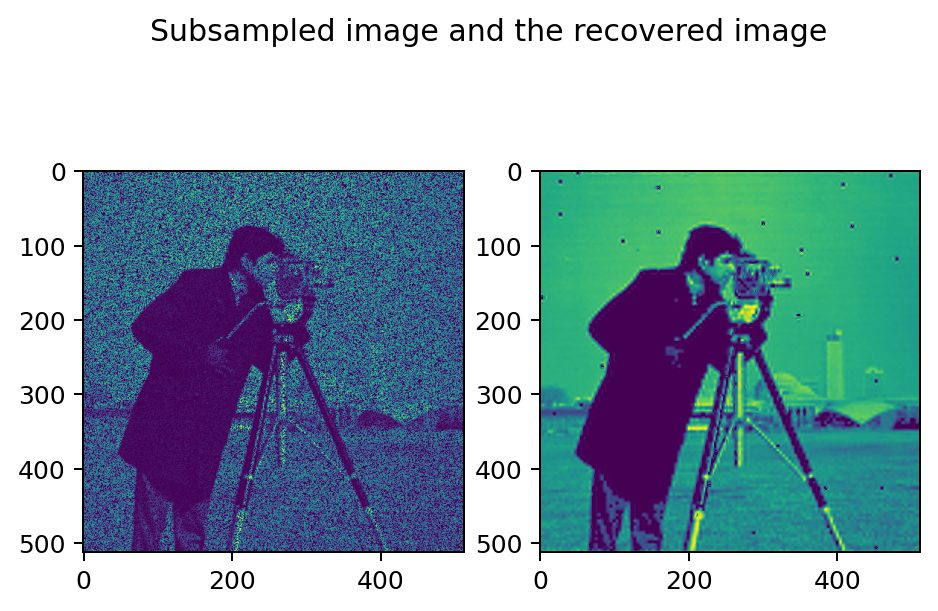

In [5]:
fig, axs = plt.subplots(1,2, dpi=180)
fig.suptitle('Subsampled image and the recovered image')
plt1 = axs[0].imshow(P_omega.rmatvec(b).reshape(512,512), vmin = 0, vmax=256)
plt2 = axs[1].imshow(Wave2d.rmatvec(x).reshape(512,512), vmin = 0, vmax=256)
fig.show()

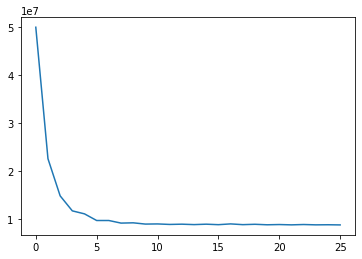

In [6]:
plt.plot(opt_log['iterations']['fx'])